In [1]:
# ML model and feature exploration

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import os

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
# model building
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

In [22]:
local_path = os.getcwd()
print(local_path)

file_location = '..\..\data\Data_Preprocessed'
    
df=pd.read_parquet(os.path.join(local_path, file_location, "df_tweets_Shashank_features_added_part1.parquet"))
df=pd.concat([df,pd.read_parquet(os.path.join(local_path, file_location, "df_tweets_Shashank_features_added_part2.parquet")) ])



c:\Users\Jithin\Desktop\erdos_fall_2021\project\ML_models\Tweet_Prediction


In [23]:
df2 = df.copy(deep=True)

In [26]:
df2.columns

Index(['created_at', 'entities_cashtags', 'entities_hashtags', 'entities_urls',
       'public_metrics_like_count', 'public_metrics_quote_count',
       'public_metrics_reply_count', 'public_metrics_retweet_count', 'text',
       'entities_mentions', 'created_at_user',
       'public_metrics_followers_count', 'public_metrics_following_count',
       'public_metrics_listed_count', 'public_metrics_tweet_count',
       'media_type', 'Company_name', 'Word_count_News_agencies',
       'Word_count_Henry08_pos', 'Word_count_Henry08_neg',
       'Word_count_LM11_pos', 'Word_count_LM11_neg',
       'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
       'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader',
       'Positive_vader', 'Negative_vader', 'Neutral_vader', 'Company_ticker'],
      dtype='object')

In [34]:
parameters_to_keep = ['entities_hashtags', 'entities_cashtags','entities_urls','public_metrics_followers_count',
                    'public_metrics_following_count', 'public_metrics_listed_count','public_metrics_tweet_count','media_type','entities_mentions',
                    'Word_count_Henry08_pos', 'Word_count_Henry08_neg',
                    'Word_count_LM11_pos', 'Word_count_LM11_neg',
                    'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
                    'Tweet_Length_characters', 'Compound_vader','Positive_vader', 'Negative_vader', 'Neutral_vader']

for col in df2.columns:
    if col not in parameters_to_keep:
        df2=df2.drop(col,axis=1)

In [35]:
sc = StandardScaler()
df2 = pd.DataFrame(sc.fit_transform(df2), columns=df2.columns)

In [36]:
df2.columns

Index(['entities_cashtags', 'entities_hashtags', 'entities_urls',
       'entities_mentions', 'public_metrics_followers_count',
       'public_metrics_following_count', 'public_metrics_listed_count',
       'public_metrics_tweet_count', 'media_type', 'Word_count_Henry08_pos',
       'Word_count_Henry08_neg', 'Word_count_LM11_pos', 'Word_count_LM11_neg',
       'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
       'Tweet_Length_characters', 'Compound_vader', 'Positive_vader',
       'Negative_vader', 'Neutral_vader'],
      dtype='object')

<AxesSubplot:>

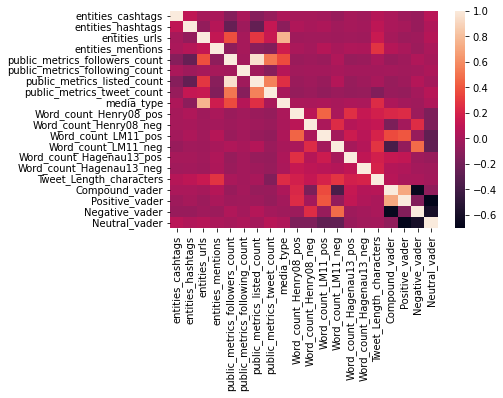

In [37]:
sns.heatmap(df2.corr(), vmax=1.0)

In [9]:
import pickle

with open('lgbm_scaler.pickle', 'wb') as f:
    pickle.dump(sc, f)

In [38]:
y_likes = df["public_metrics_like_count"].apply(lambda x: 1 if x > 20  else 0 )
y_retweets= df["public_metrics_retweet_count"].apply(lambda x: 1 if x > 20  else 0 )
X = df2  
print(f'fraction of tweets more than 20 likes and those less than 20 likes: {sum(y_likes)/len(y_likes)} , {1-(sum(y_likes)/len(y_likes))}')
print(f'fraction of tweets more than 20 Retweets and those less than 20 Retweets: {sum(y_retweets)/len(y_retweets)} , {1-(sum(y_retweets)/len(y_retweets))}')



fraction of tweets more than 20 likes and those less than 20 likes: 0.5560581855240382 , 0.4439418144759618
fraction of tweets more than 20 Retweets and those less than 20 Retweets: 0.23744946819270812 , 0.7625505318072918


In [39]:

X_train, X_test, y_train, y_test = train_test_split(X, y_likes,
                                                    test_size = .2,
                                                    random_state=123,
                                                    shuffle=True,
                                                    stratify=y_likes)



In [40]:
X_train.head()

,entities_cashtags,entities_hashtags,entities_urls,entities_mentions,public_metrics_followers_count,public_metrics_following_count,public_metrics_listed_count,public_metrics_tweet_count,media_type,Word_count_Henry08_pos,Word_count_Henry08_neg,Word_count_LM11_pos,Word_count_LM11_neg,Word_count_Hagenau13_pos,Word_count_Hagenau13_neg,Tweet_Length_characters,Compound_vader,Positive_vader,Negative_vader,Neutral_vader
133053,-0.174954,-0.377196,-0.472546,-0.400621,2.091887,-0.101726,2.040775,1.357856,-0.827898,-0.447282,-0.317411,-0.447356,0.720007,2.073967,-0.349027,1.595979,-0.429544,-0.812741,-0.248039,0.834401
613490,-0.174954,-0.377196,-2.163424,-0.400621,-0.730703,-0.205392,-0.799133,-1.374329,-0.827898,-0.447282,-0.317411,-0.447356,-0.578010,-0.344208,-0.349027,-0.263533,-1.477485,-0.812741,0.761876,0.110384
228,1.165580,-0.377196,-0.472546,-0.400621,-0.773852,-0.175591,-0.779019,-1.166205,-0.827898,-0.447282,-0.317411,-0.447356,0.720007,-0.344208,-0.349027,-0.853134,-0.178791,-0.812741,-0.642719,1.117350
67174,-0.174954,-0.377196,1.218331,-0.400621,2.091893,-0.101726,2.040775,1.357885,1.207878,-0.447282,-0.317411,-0.447356,-0.578010,-0.344208,-0.349027,-0.853134,0.802494,1.381478,-0.642719,-0.655243
859799,-0.174954,-0.377196,-0.472546,1.324856,-0.278052,-0.143371,-0.907135,0.213321,-0.827898,-0.447282,-0.317411,-0.447356,-0.578010,-0.344208,-0.349027,-0.671719,-0.178791,-0.812741,-0.642719,1.117350


array([[<AxesSubplot:title={'center':'entities_cashtags'}>,
        <AxesSubplot:title={'center':'entities_hashtags'}>,
        <AxesSubplot:title={'center':'entities_urls'}>,
        <AxesSubplot:title={'center':'entities_mentions'}>],
       [<AxesSubplot:title={'center':'public_metrics_followers_count'}>,
        <AxesSubplot:title={'center':'public_metrics_following_count'}>,
        <AxesSubplot:title={'center':'public_metrics_listed_count'}>,
        <AxesSubplot:title={'center':'public_metrics_tweet_count'}>],
       [<AxesSubplot:title={'center':'media_type'}>,
        <AxesSubplot:title={'center':'Word_count_Henry08_pos'}>,
        <AxesSubplot:title={'center':'Word_count_Henry08_neg'}>,
        <AxesSubplot:title={'center':'Word_count_LM11_pos'}>],
       [<AxesSubplot:title={'center':'Word_count_LM11_neg'}>,
        <AxesSubplot:title={'center':'Word_count_Hagenau13_pos'}>,
        <AxesSubplot:title={'center':'Word_count_Hagenau13_neg'}>,
        <AxesSubplot:title={'center

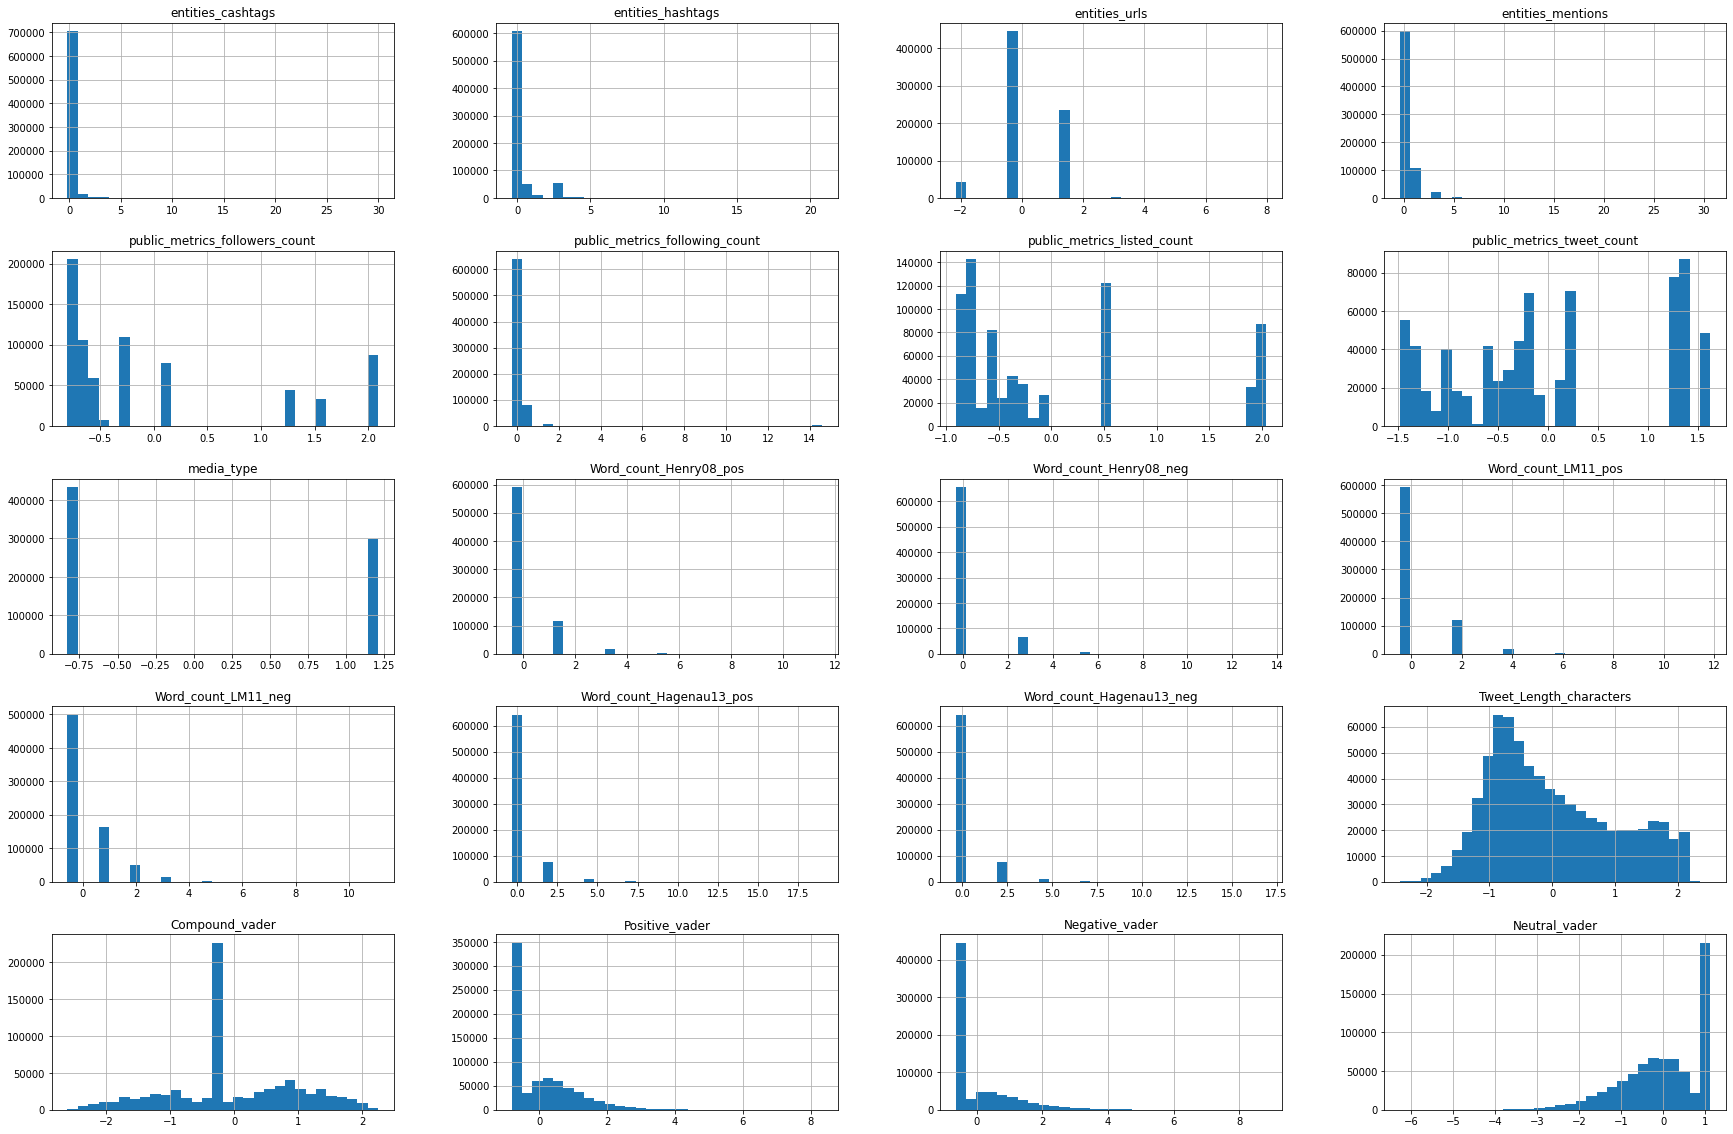

In [41]:
X_train.hist(bins=30, figsize=(30, 20))

In [42]:
y_train

133053    1
613490    1
228       0
67174     1
859799    0
         ..
403259    1
619017    0
255780    0
793324    0
412412    0
Name: public_metrics_like_count, Length: 731618, dtype: int64

In [43]:
df.iloc[403259]

created_at                                                      2021-08-03 07:28:04
entities_cashtags                                                                 0
entities_hashtags                                                                 0
entities_urls                                                                     1
public_metrics_like_count                                                        32
public_metrics_quote_count                                                        0
public_metrics_reply_count                                                        3
public_metrics_retweet_count                                                     18
text                              It's not just about heatwaves in the U.S. and ...
entities_mentions                                                                 0
created_at_user                                                 2009-04-23 16:05:17
public_metrics_followers_count                                              

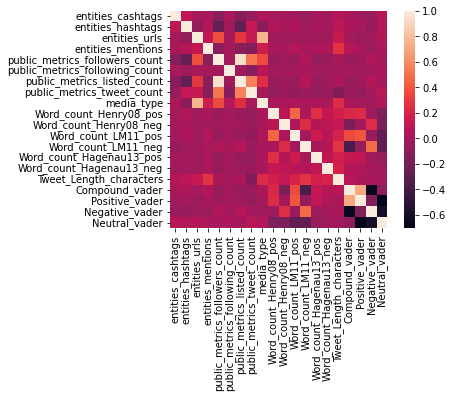

In [44]:
corrmat = X_train.corr()
sns.heatmap(corrmat, vmax=1.0, square=True);

# Light Gradient boosting model

In [57]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

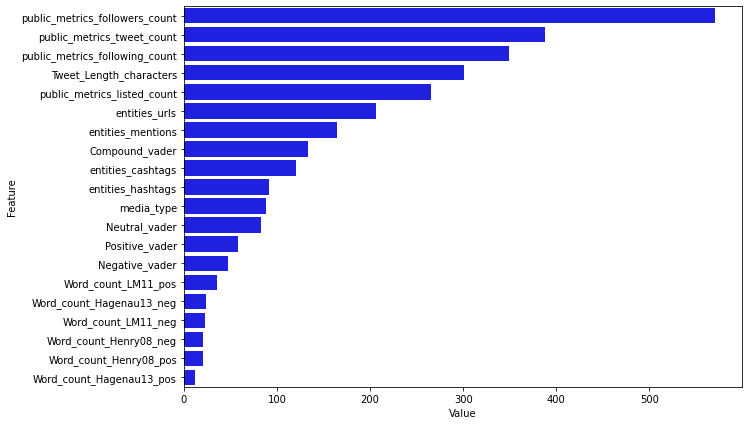

In [58]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:], color='blue');

In [59]:
predictions = clf.predict(X_test)


In [60]:
class_report = classification_report(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

print ('report :', class_report)
print('accuracy :',accuracy)
print('f1_score ', f1_score(y_test, predictions, average='weighted'))
print('roc_auc score = ', roc_auc_score(y_test, predictions))

report :               precision    recall  f1-score   support

           0       0.87      0.81      0.84     81199
           1       0.86      0.90      0.88    101706

    accuracy                           0.86    182905
   macro avg       0.86      0.86      0.86    182905
weighted avg       0.86      0.86      0.86    182905

accuracy : 0.8633060878598179
f1_score  0.8627156512784093
roc_auc score =  0.8581801097738401


[[65971 15228]
 [ 9774 91932]]


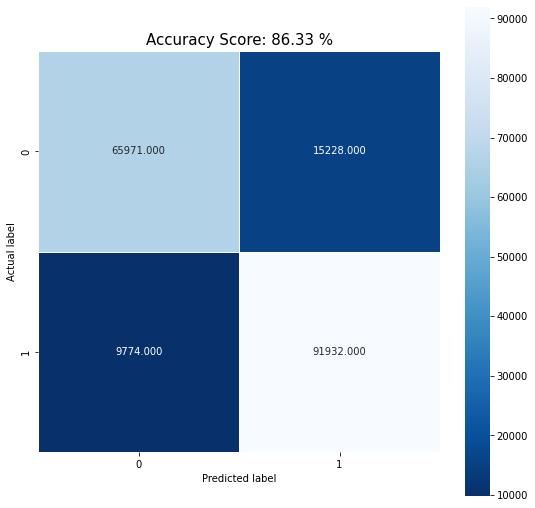

In [21]:
cm = confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(accuracy*100, 2))
plt.title(all_sample_title, size = 15)
plt.show()

In [22]:
import pickle

with open('lgbm_model.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [23]:
import numpy as np

with open('lgbm_model.pickle', 'rb') as f:
    model_ = pickle.load(f)
x_new = X_test.iloc[0].values.reshape(1,-1)
print(  x_new.shape   )
predictions_new = model_.predict( x_new )
print(predictions_new)
# print ('report :', classification_report(y_test, predictions_new))
# print('accuracy :',accuracy_score(y_test, predictions_new))
# print('f1_score ', f1_score(y_test, predictions_new, average='weighted'))

(1, 20)
[1]


c:\Users\Jithin\Desktop\erdos_fall_2021\project\.venv\lib\site-packages\lightgbm\basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


# Logistic regression


In [24]:
# Logistic regression

In [61]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
lr_predictions  = logisticRegr.predict(X_test)

Feature: 0 entities_cashtags, Score: 0.011079226071885107
Feature: 1 entities_hashtags, Score: -0.13541324357226256
Feature: 2 entities_urls, Score: -0.7050317465958377
Feature: 3 entities_mentions, Score: -0.07435734317486183
Feature: 4 public_metrics_followers_count, Score: 1.6598346632368923
Feature: 5 public_metrics_following_count, Score: 0.15061714081565966
Feature: 6 public_metrics_listed_count, Score: 0.048758339808213244
Feature: 7 public_metrics_tweet_count, Score: -0.22062789734344632
Feature: 8 media_type, Score: 0.4709801568284454
Feature: 9 Word_count_Henry08_pos, Score: 0.009543257739138205
Feature: 10 Word_count_Henry08_neg, Score: -0.023785909736354752
Feature: 11 Word_count_LM11_pos, Score: -0.006754655219994934
Feature: 12 Word_count_LM11_neg, Score: 0.015018704503020234
Feature: 13 Word_count_Hagenau13_pos, Score: -0.04138803058282222
Feature: 14 Word_count_Hagenau13_neg, Score: -0.05496858761204221
Feature: 15 Tweet_Length_characters, Score: 0.1502779710197333
Feat

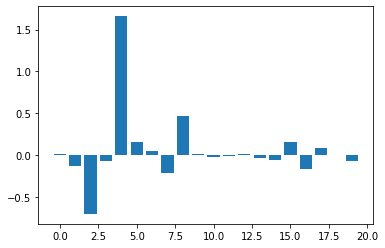

In [62]:
importance = logisticRegr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: {} {}, Score: {}'.format(i, df2.columns[i], v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

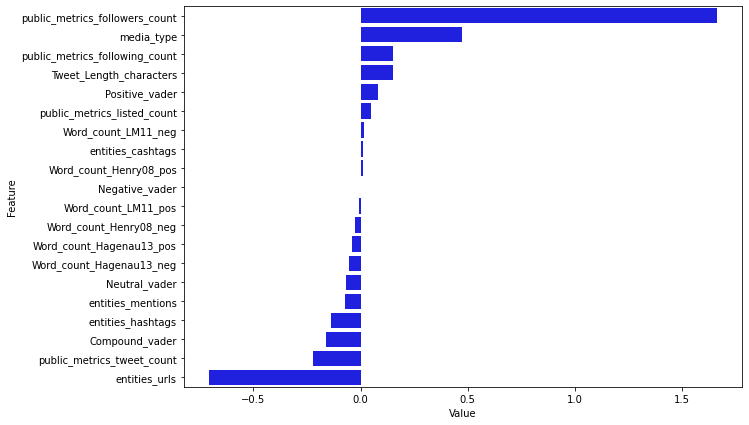

In [63]:
lr_feature_imp = pd.DataFrame(sorted(zip(logisticRegr.coef_[0],X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 7))
sns.barplot(x="Value", y="Feature", data=lr_feature_imp.sort_values(by="Value", ascending=False)[:], color='blue');

In [64]:
lr_class_report = classification_report(y_test, lr_predictions)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print ('report :', lr_class_report)
print('accuracy :',lr_accuracy)
print('f1_score ', f1_score(y_test, lr_predictions, average='weighted'))
print('roc_auc score = ', roc_auc_score(y_test, lr_predictions))

report :               precision    recall  f1-score   support

           0       0.68      0.77      0.72     81199
           1       0.80      0.71      0.75    101706

    accuracy                           0.74    182905
   macro avg       0.74      0.74      0.74    182905
weighted avg       0.75      0.74      0.74    182905

accuracy : 0.739717339602526
f1_score  0.7405372262626146
roc_auc score =  0.7429314087724819


[[62653 18546]
 [29061 72645]]


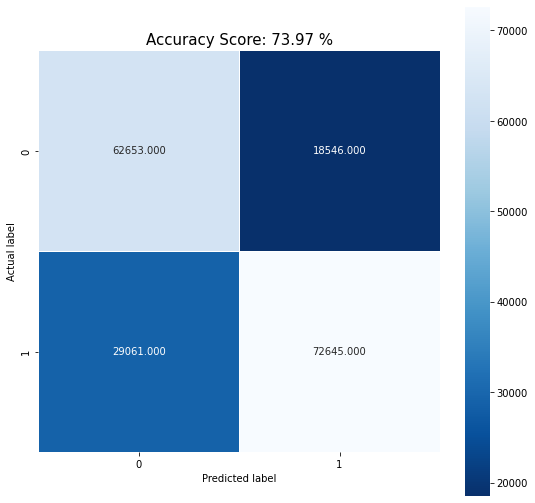

In [51]:
lr_cm = confusion_matrix(y_test, lr_predictions)
print(lr_cm)
plt.figure(figsize=(9,9))
sns.heatmap(lr_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(lr_accuracy*100, 2))
plt.title(all_sample_title, size = 15)
plt.show()

# Naive Bayes model

In [69]:
naiveBayes = GaussianNB()
naiveBayes.fit(X_train, y_train)
nb_predictions  = naiveBayes.predict(X_test)

report :               precision    recall  f1-score   support

           0       0.61      0.86      0.71     81199
           1       0.83      0.56      0.67    101706

    accuracy                           0.69    182905
   macro avg       0.72      0.71      0.69    182905
weighted avg       0.73      0.69      0.69    182905

accuracy : 0.694688499494273
f1_score  0.6910057276742343
roc_auc score =  0.7111431515325602
[[69661 11538]
 [44305 57401]]


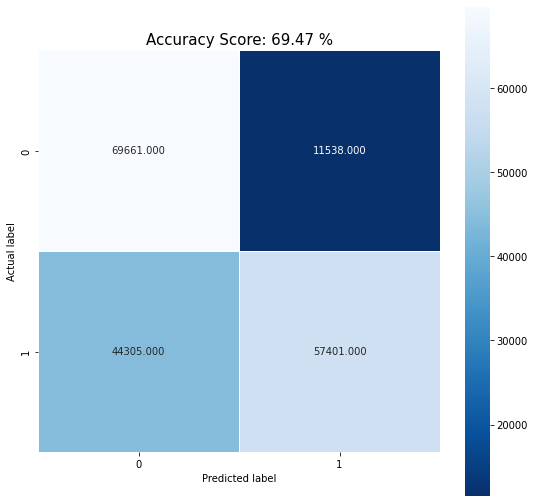

In [70]:
class_report = classification_report(y_test, nb_predictions)
accuracy = accuracy_score(y_test, nb_predictions)

print ('report :', class_report)
print('accuracy :',accuracy)
print('f1_score ', f1_score(y_test, nb_predictions, average='weighted'))
print('roc_auc score = ', roc_auc_score(y_test, nb_predictions))

cm = confusion_matrix(y_test, nb_predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0} %'.format(round(accuracy*100, 2))
plt.title(all_sample_title, size = 15)
plt.show()

In [54]:
imps = permutation_importance(naiveBayes, X_test, y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]
features = X_test.columns
# Print the feature ranking
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. public_metrics_followers_count (0.055962)
2. public_metrics_listed_count (0.048250)
3. entities_hashtags (0.004113)
4. public_metrics_tweet_count (0.003749)
5. entities_urls (0.001886)
6. public_metrics_following_count (0.001731)
7. entities_mentions (0.001524)
8. Word_count_LM11_neg (0.001224)
9. entities_cashtags (0.001083)
10. Compound_vader (0.000477)
11. Negative_vader (0.000388)
12. Tweet_Length_characters (0.000035)
13. Word_count_Hagenau13_neg (0.000022)
14. Positive_vader (-0.000024)
15. Neutral_vader (-0.000071)
16. Word_count_LM11_pos (-0.000073)
17. Word_count_Henry08_neg (-0.000085)
18. Word_count_Hagenau13_pos (-0.000086)
19. Word_count_Henry08_pos (-0.000173)
20. media_type (-0.001163)


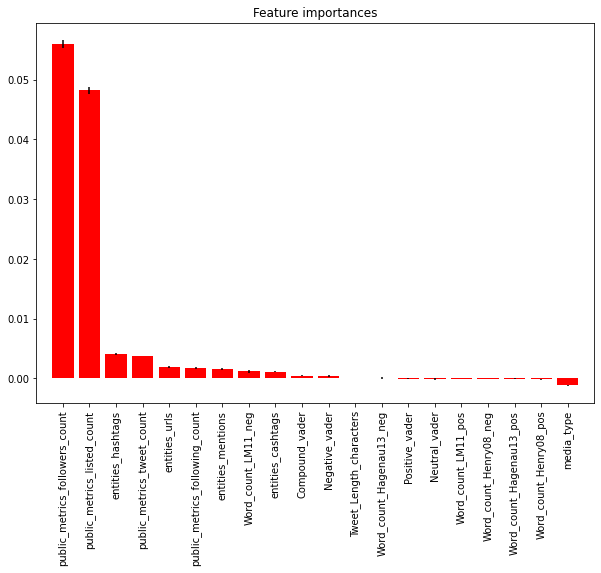

In [55]:
plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(20)] , rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.show()
